# Setup

In [1]:
import pickle
from quebap.projects.autoread import sampler_for, model_from_config
import tensorflow as tf

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open("models/100_dr0.2/config.pickle", 'rb') as f:
    model_config = pickle.load(f)

In [3]:
model = model_from_config(model_config)

In [4]:
rev_vocab = [""] * len(model.embedder.vocab)
for w, i in model.embedder.vocab.items():
    rev_vocab[i] = w

In [5]:
sess = tf.InteractiveSession()

In [6]:
sess.run(tf.initialize_all_variables())
model.model_saver.restore(sess, "models/100_dr0.2/model.ckpt-280")
model.set_eval(sess)

In [7]:
sampler = sampler_for("squad", "qa", sess, "data/BioASQ", ["dev.json"], 1, vocab=model.embedder.vocab)

# Helpers

Print functions:

In [8]:
def print_question(batch):
    question = [rev_vocab[w] for w in b[0].question]
    print("Question:")
    print(' '.join(question))
    print()

def print_answers(batch):
    answers = [' '.join([rev_vocab[w] for w in a]) for a in b[0].answers]
    print("Answers:")
    print(answers)
    print()

def print_predicted(batch, answer_start, answer_end):
    predicted =  " ".join([rev_vocab[i] for i in b[0].context[answer_start:answer_end+1]])
    print("Predicted:")
    print(predicted)
    print()

def print_context(batch):
    context = [rev_vocab[w] for w in b[0].context]
    print("Context:")
    print(' '.join(context))
    print()

Find best answer span via beam search:

In [9]:
def softmax(w):
    e = np.exp(w)
    dist = e / np.sum(e)
    return dist

In [10]:
def find_best_answer_span(batch, beam_size=4):
    model.set_top_k(sess, beam_size)
    start_p, end_p, start_scores, end_scores = model.run(sess, [model.predicted_answer_starts, 
                                                                model.predicted_answer_ends,
                                                                model.start_scores,
                                                                model.end_scores], batch)
    
    start_probs = softmax(start_scores)
    end_probs = softmax(end_scores)
    
    selected_start_probs = start_probs[0, start_p]
    row_indices = [i for i in range(beam_size) for j in range(beam_size)]
    selected_end_probs = end_probs[row_indices, end_p]
    
    total_scores = selected_start_probs * selected_end_probs
    best_span_index = np.argmax(total_scores)
    
    return start_p[best_span_index], end_p[best_span_index], total_scores[best_span_index]

Helper to find the "correct" tokens in the context:

In [11]:
def find_correct_tokens(batch):
    """Returns a boolean np array of length len(tokens) that states if the token is part of an answer."""
    answers = b[0].answers
    tokens = b[0].context
    
    is_correct = np.zeros(len(tokens), dtype=np.bool)
    for i, start_token in enumerate(tokens):
        for answer in answers:
            if start_token == answer[0] and len(tokens) - i >= len(answer):
                all_correct = True
                for j in range(1, len(answer)):
                    all_correct &= tokens[i + j] == answer[j]
                if all_correct:
                    for j in range(0, len(answer)):
                        is_correct[i + j] = True
    
    return is_correct

Plot helper:

In [12]:
def text_heatmap(tokens, scores, token_highlight=None):
    
    if token_highlight is None:
        token_highlight = np.zeros(len(tokens), dtype=np.bool)
    
    tokens_per_row = 10
    num_rows = math.ceil(len(tokens) / tokens_per_row)
    s_min, s_max = scores.min(), scores.max()

    f, axes = plt.subplots(num_rows, figsize=(15, num_rows / 2))
    for row in range(num_rows):
        
        axis = axes[row] if num_rows > 1 else axes

        axis.pcolor(scores[:, row * tokens_per_row:(row + 1) * tokens_per_row],
                    cmap="YlOrBr", vmin=s_min, vmax=s_max)

        axis.get_yaxis().set_visible(False)
        axis.get_xaxis().set_visible(False)

        for i in range(tokens_per_row):
            token_index = row * tokens_per_row + i
            token = tokens[token_index] if token_index < len(tokens) else ""
            is_highlighted = token_highlight[token_index] if token_index < len(tokens) else False
            color = "Green" if is_highlighted else "Black"
            axis.text(i + 0.5, 0.5, token,
                           color=color,
                           horizontalalignment='center',
                           verticalalignment='center')

# Visualizations

## Run Model

In [13]:
model.set_top_k(sess, 4)
b = sampler.get_batch()

start_p, end_p, start_scores, end_scores, question_attention_scores = model.run(
    sess, [model.predicted_answer_starts, 
           model.predicted_answer_ends,
           model.start_scores,
           model.end_scores,
           model.question_attention_scores], b)

answer_start, answer_end, score = find_best_answer_span(b, 4)
score

0.036947221

## Answer Question (beam search (2) answers)

In [14]:
predicted = [rev_vocab[w] for w in b[0].context[start_p[0]:end_p[0]+1]]

print_question(b)
print_answers(b)
print_predicted(b, answer_start, answer_end)
print_context(b)

Question:
in which types of dna repair is the uvrab complex involved <UNK>

Answers:
['nucleotide excision repair <UNK> ner <UNK>', 'nucleotide excision repair <UNK> ner <UNK>', 'transcription - coupled repair <UNK> tcr <UNK>']

Predicted:
uvrb

Context:
illegitimate recombination is mostly suppressed by uvra and uvrb <UNK> uvrab complex suppresses illegitimate recombination transcription - coupled repair <UNK> tcr <UNK> is a subpathway of nucleotide excision repair <UNK> ner <UNK> that acts specifically on lesions in the transcribed strand of expressed genes <UNK> the transcription repair coupling factor <UNK> mfd <UNK> this protein recruits the ner lesion - recognition factor uvra <UNK> and then dissociates from the dna <UNK> uvra binds uvrb <UNK> and the assembled uvrab <UNK> complex initiates repair <UNK> uvrb plays a key role in bacterial nucleotide excision repair <UNK> it is the ultimate damage - binding protein that interacts with both uvra and uvrc <UNK> uvrb subunits bind to 

## Pointer Visualization

Start pointer scores visualisation. Correct tokens are highlighted.

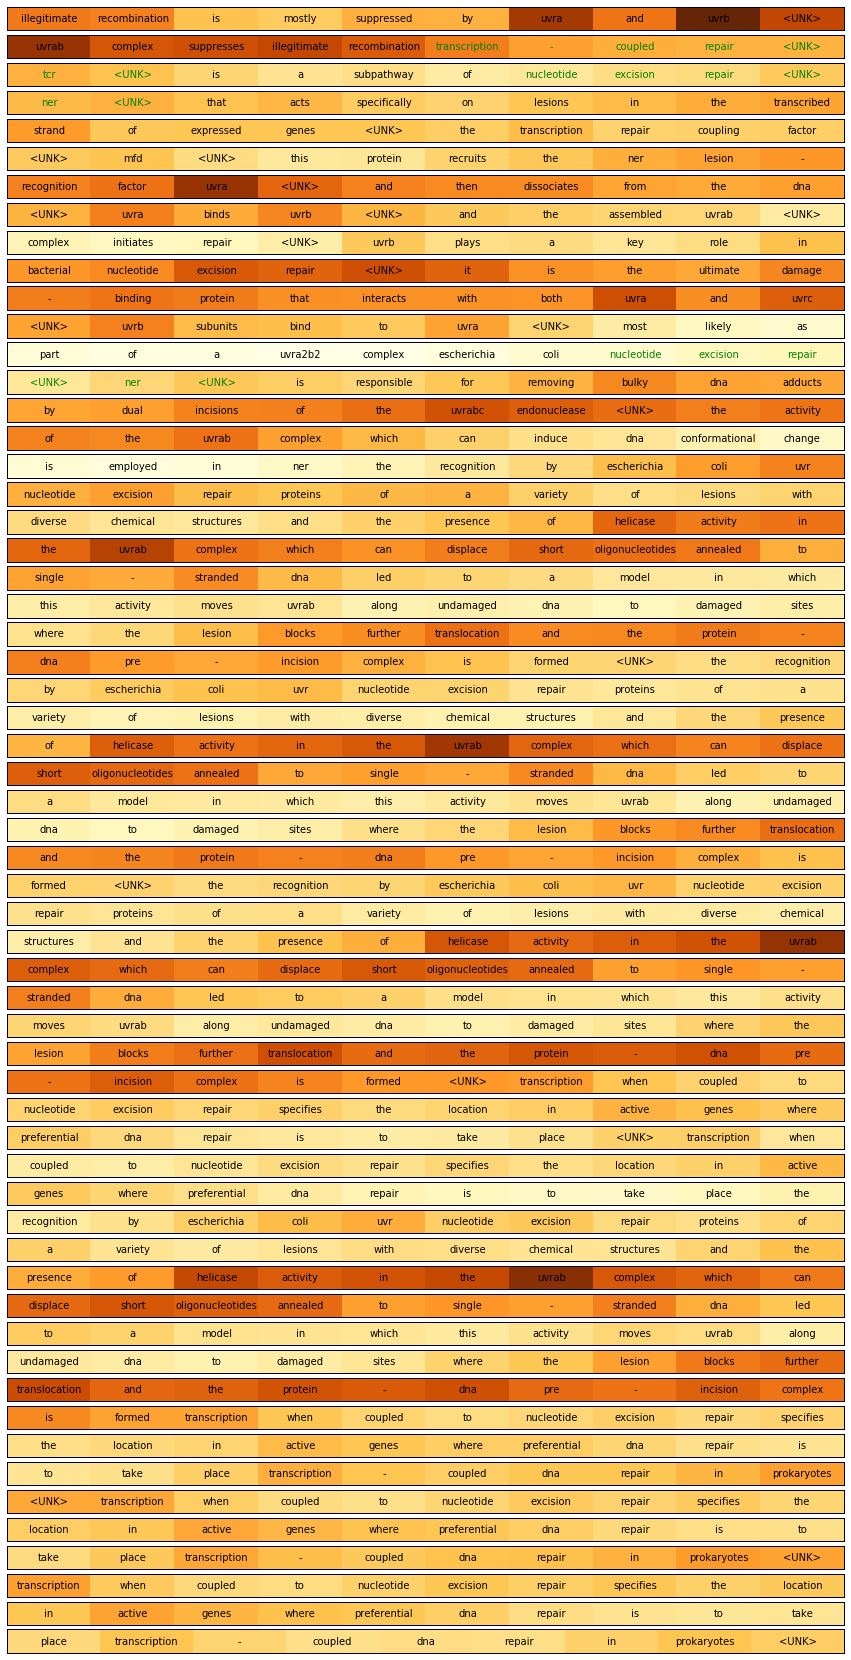

In [15]:
tokens = [rev_vocab[w] for w in b[0].context]
correct_tokens = find_correct_tokens(b)

text_heatmap(tokens, start_scores, correct_tokens)

End pointer visualization for the highest-scoring start pointer. Start token is highlighted.

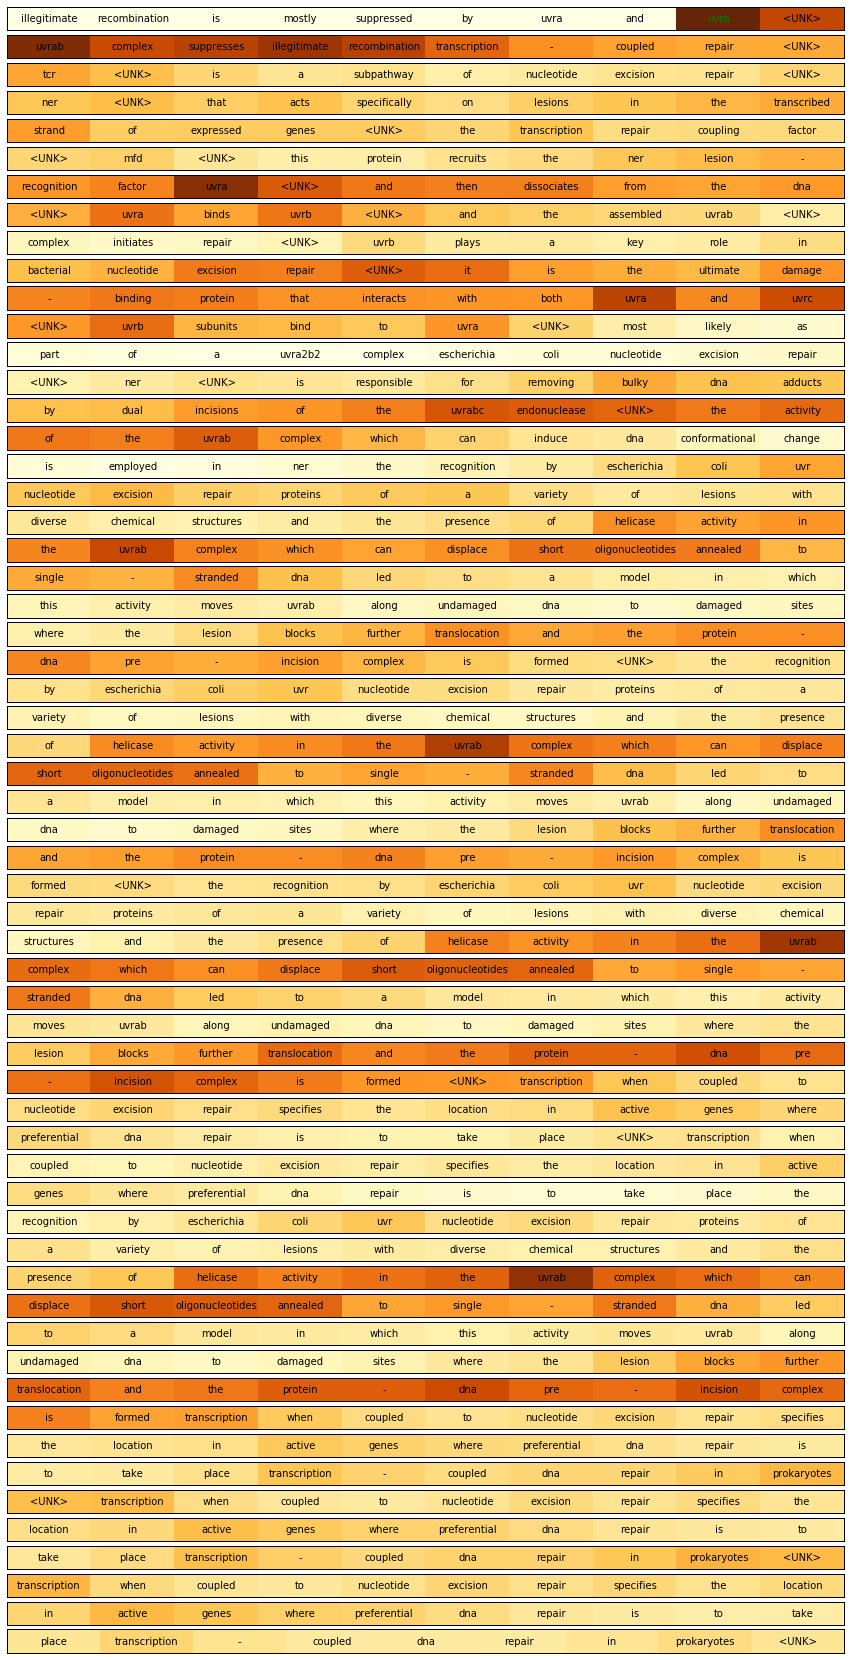

In [16]:
tokens = [rev_vocab[w] for w in b[0].context]
start_token_mask = np.zeros(len(tokens), dtype=np.bool)
start_token_mask[start_p[0]] = True

# Ignore tokens before the start token, because those are going to have a large negative score
filtered_end_scores = end_scores.copy()
filtered_end_scores[[0], :start_p[0]] = end_scores[0, start_p[0]:].min()

text_heatmap(tokens, filtered_end_scores[[0], :], start_token_mask)

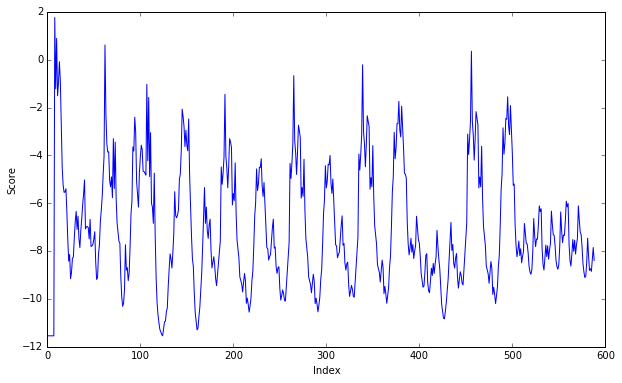

In [17]:
plt.plot(filtered_end_scores[0, :])
xlabel("Index")
ylabel("Score")

## Question Attention Visualisation

Attention scores over the question preprocessing vectors. Note that while there is one vector per question token, the vector potentially contains information of surrounding tokens as well.

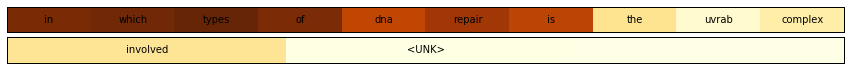

In [18]:
tokens = [rev_vocab[w] for w in b[0].question]
text_heatmap(tokens, question_attention_scores)

# Evaluation

Get all question batches:

In [19]:
def get_batches(sampler):
    sampler.reset()
    start_epoch = sampler.epoch
    batches = []

    while sampler.epoch == start_epoch:
        batches.append(sampler.get_batch())
    
    return batches

In [20]:
def evaluate_batch(batch, beam_size):

    answer_start, answer_end, _ = find_best_answer_span(batch, beam_size)

    start_token_correct = False
    full_answer_correct = False

    context = batch[0].context

    for answer in batch[0].answers:
        if answer[0] == context[answer_start]:
            start_token_correct = True
            if answer_end - answer_start + 1 == len(answer):
                all_correct = True
                for i, token in enumerate(answer):
                    if token != context[answer_start + i]:
                        all_correct = False
                        break
                full_answer_correct |= all_correct
                
    return start_token_correct, full_answer_correct

In [21]:
def evaluate_all(batches, beam_size):
    results = np.array([evaluate_batch(b, beam_size) for b in batches])
    correct_start, correct_full = results.sum(0)
    print("Correct start tokens: %d%%" % int(correct_start / len(batches) * 100))
    print("Correct full answer: %d%%" % int(correct_full / len(batches) * 100))

## Dev Evaluation

In [22]:
batches = get_batches(sampler)
    
len(batches)

100

Evaluate with different beam sizes:

In [23]:
evaluate_all(batches, 4)

Correct start tokens: 44%
Correct full answer: 28%


In [24]:
evaluate_all(batches, 1)

Correct start tokens: 49%
Correct full answer: 31%


## Train Evaluation

In [25]:
train_sampler = sampler_for("squad", "qa", sess, "data/BioASQ", ["train.json"], 1, vocab=model.embedder.vocab)
batches = get_batches(train_sampler)[:100]
len(batches)

100

In [26]:
evaluate_all(batches, 1)

Correct start tokens: 49%
Correct full answer: 31%
